### Import Libraries

In [390]:
import warnings
warnings.filterwarnings('ignore')

In [343]:
seed = 2018
import math
import numpy as np
import edward as ed
import pandas as pd
import tensorflow as tf
np.random.seed(seed= seed)
# ed.set_seed(seed)

from time import time
from edward.models import Categorical, Normal
from keras.utils import to_categorical
from plot_feature import plot_feature

import seaborn as sns
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.utils import resample
import scipy.special
from matplotlib.mlab import griddata
import matplotlib.tri as tri

In [3]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show, output_notebook
output_notebook()
TOOLS = 'save, zoom_in, zoom_out, hover, pan'

Loading BokehJS ...

### Sklearn related modules

In [4]:
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA

### Plot related setups

In [239]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
%matplotlib inline

plt.style.use(['default'])
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'font.family': 'serif',
}
plt.rcParams.update(params)

### Import Data

In [6]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None, dtype = np.float32)
df_val= pd.read_csv(val_file, sep=" ", header = None, dtype = np.float32)
df_test= pd.read_csv(test_file, sep=" ", header = None, dtype = np.float32)

features_name =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = df_train.append(df_val)

### Data processing
We use StandardScaler preprocessing method of scikit. It standardizes features 
by removing the mean and scaling to unit variance

In [7]:
df = shuffle(df_train_all, random_state = seed)
df_test = shuffle(df_test, random_state = seed)

In [8]:
df.shape

(1600, 9)

### Class Balance

In [9]:
df.label.value_counts()

0.0    1041
1.0     559
Name: label, dtype: int64

In [10]:
df_major = df[df.label == 0]
df_minor = df[df.label == 1]

In [11]:
df_minor.shape[0]

559

In [12]:
df_minor_upsmapled = resample(df_minor, replace = True, n_samples = df_major.shape[0], random_state = 2018)

In [13]:
df_minor_upsmapled = pd.concat([df_minor_upsmapled, df_major])

In [14]:
df_minor_upsmapled.label.value_counts()

0.0    1041
1.0    1041
Name: label, dtype: int64

### Analysis

In [15]:
features =['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc']

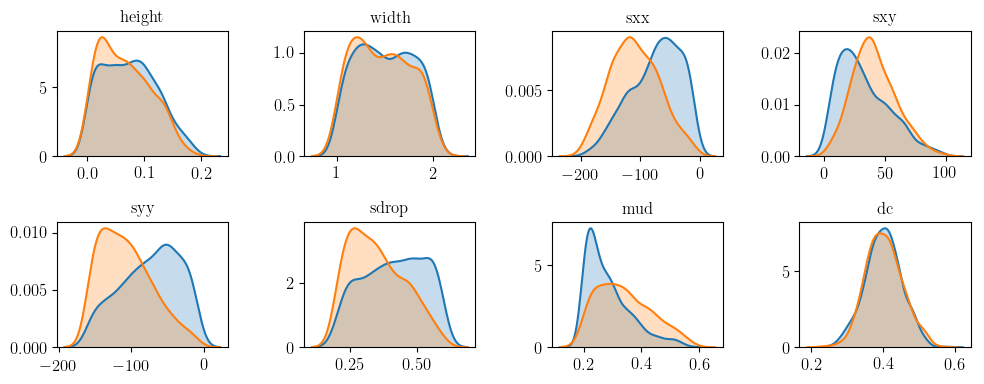

In [16]:
plt.figure(figsize=(10, 4))

for i, feature in enumerate(features):
    plt.subplot(2, 4, i + 1)
    sns.kdeplot(df[feature][df.label == 0], shade= True, legend=False)
    sns.kdeplot(df[feature][df.label == 1], shade= True, legend=False)
    plt.title(feature)
    
plt.tight_layout()
plt.show()

### Fetaure Scaling

In [17]:
mms = StandardScaler()
train_scale = mms.fit(df_minor_upsmapled.drop('label', axis=1))

xtrain = train_scale.transform(df_minor_upsmapled.drop('label', axis=1))
ytrain =  np.array(df_minor_upsmapled['label'].values)
ytrain = ytrain.reshape(ytrain.shape[0], 1)

xtest = train_scale.transform(df_test.drop('label', axis=1))
ytest = np.array(df_test['label'].values)
ytest = ytest.reshape(ytest.shape[0], 1)

In [18]:
np.shape(xtrain)

(2082, 8)

### Feature analysis

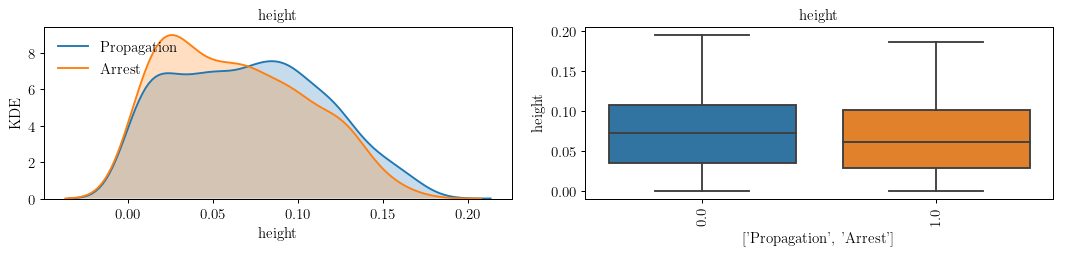

In [19]:
plot_feature(df, 'height', True, False)

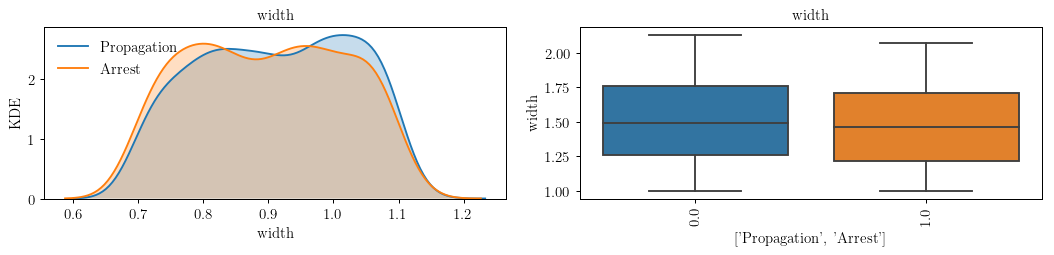

In [20]:
plot_feature(df, 'width', True, False)

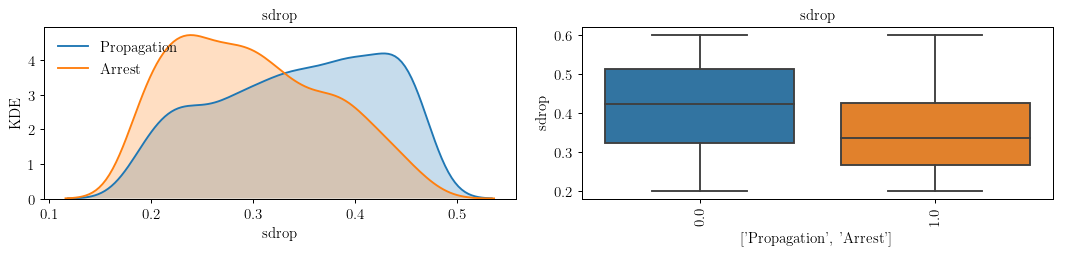

In [21]:
plot_feature(df, 'sdrop', True, False)

In [22]:
from sklearn.linear_model import Lasso, Ridge

In [23]:
#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (np.round(coef, 3), name)
                                   for coef, name in lst)

In [24]:
lasso = Lasso(alpha=0.0005)
lasso.fit(xtrain, ytrain)
print("Lasso model: ", pretty_print_linear(lasso.coef_, features, sort = False))

ridge = Ridge(alpha=10)
ridge.fit(xtrain, ytrain)
print("Ridge model: ", pretty_print_linear(ridge.coef_, features, sort = False))

Lasso model:  -0.032 * height + -0.018 * width + -0.085 * sxx + -0.002 * sxy + -0.098 * syy + -0.049 * sdrop + 0.111 * mud + 0.008 * dc
Ridge model:  [-0.032 -0.019 -0.086 -0.008 -0.103 -0.046  0.111  0.008] * height


## Model setup

### 1. Hyperparameters 

In [25]:
## Hyperparameters
N = np.shape(xtrain)[0]
in_size = np.shape(xtrain)[1]
out_size = 1
l1 = 12 # Number of neurons in the first layer
BATCH_SIZE = 32

### 2. Define neural network

In [26]:
def neural_network(X, W_0, W_1, b_0, b_1):
    hidden1 = tf.nn.relu(tf.matmul(X, W_0) + b_0)
    output = tf.nn.sigmoid(tf.matmul(hidden1, W_1) + b_1)
    return output

In [27]:

with tf.name_scope('model_prior'):
    
    W_0 = Normal(loc = tf.zeros([in_size, l1], name="weights/loc_w_0"), 
                 scale=tf.ones([in_size, l1], name="weights/scale_w_0"),
                 name  = 'weight_w_0')
    W_1 = Normal(loc=tf.zeros([l1, out_size], name="weights/loc_w_1"), 
                 scale=tf.ones([l1, out_size], name="weights/scale_w_1"),
                 name  = 'weight_w_1')
    b_0 = Normal(loc=tf.zeros(l1, name="weights/loc_b_0"), 
                 scale=tf.ones(l1, name="weights/scale_b_0"),
                 name  = 'weight_b_0')
    b_1 = Normal(loc=tf.zeros(out_size, name="weights/loc_b_1"),
                 scale=tf.ones(out_size, name="weights/scale_b_1"),
                 name  = 'weight_b_1')
    
    X = tf.placeholder(tf.float32, shape = (None, in_size)) 
    y = Normal(loc = neural_network(X, W_0, W_1, b_0, b_1), scale = 1.0)

### 3. Model Prior parameter distributions

In [28]:
with tf.name_scope('posterior'):
    qW_0 = Normal(loc = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/loc_qw_0" ), 
                  scale = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/scale_qw_0"),
                  name = "weight_qw_0")
    
    qW_1 = Normal(loc = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ), 
                  scale = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ),
                  name = "weight_qw_1")
    
    qb_0 = Normal(loc = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ), 
                scale = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ),
                name = "weight_qb_0")
    qb_1 = Normal(loc = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ), 
                scale = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ),
                name = "weight_qb_1")

### Model posterior weights

In [29]:
with tf.name_scope('posterior'):
    qW_0 = Normal(loc = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/loc_qw_0" ), 
                  scale = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/scale_qw_0"),
                  name = "weight_qw_0")
    
    qW_1 = Normal(loc = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ), 
                  scale = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ),
                  name = "weight_qw_1")
    
    qb_0 = Normal(loc = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ), 
                scale = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ),
                name = "weight_qb_0")
    qb_1 = Normal(loc = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ), 
                scale = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ),
                name = "weight_qb_1")

## Inference

In [30]:
with tf.name_scope("inference"):
    
    inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                         W_1: qW_1, b_1: qb_1}, 
                        data={X: xtrain, 
                              y: ytrain})

    global_step = tf.Variable(0, trainable = True, name = "global_step")
    initial_learning_rate = tf.Variable(0.001, trainable = True, name = "initial_learning_rate")

    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               10000, 0.3, staircase = True)

    optimizer = tf.train.AdamOptimizer(learning_rate)

    inference.run(n_iter = 5000, optimizer = optimizer, global_step = global_step, logdir = r'./log')

5000/5000 [100%] ██████████████████████████████ Elapsed: 10s | Loss: 2206.568


## Sampling 

In [31]:
%time

n_samples = 5000

qW_0_samples = qW_0.sample(sample_shape=n_samples)
qW_1_samples = qW_1.sample(sample_shape=n_samples)
qb_0_samples = qb_0.sample(sample_shape=n_samples)
qb_1_samples = qb_1.sample(sample_shape=n_samples)

print("Preparing to sample...")

t0 = time()
samplenodes = tf.stack([neural_network(X, qW_0_samples[i], qW_1_samples[i],
                                       qb_0_samples[i], qb_1_samples[i]) 
                        for i in range(n_samples)], axis=0)

print("Took", np.int(time() - t0), "secs.")

print("Sampling...")
t0 = time()
samplepredictions = samplenodes.eval(feed_dict={X: xtest})
print("Took", np.int(time() - t0), "secs.")
predictions_samp = samplepredictions[:, :, 0]

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.9 µs
Preparing to sample...
Took 65 secs.
Sampling...
Took 178 secs.


### Prior and posterior weight vizualization

In [32]:
### prior weights
prior_weights = W_0.eval(), W_1.eval(), b_0.eval(), b_1.eval()

### Posterior mean weights
post_weights_mean = qW_0_samples.eval().mean(axis = 0), qW_1_samples.eval().mean(axis = 0),\
               qb_0_samples.eval().mean(axis = 0), qb_1_samples.eval().mean(axis = 0)

In [33]:
### Posterior standard deviation of weights
post_weights_std = qW_0_samples.eval().std(axis = 0), qW_1_samples.eval().std(axis = 0),\
               qb_0_samples.eval().std(axis = 0), qb_1_samples.eval().std(axis = 0)

In [187]:
np.shape(prior_weights[0])

(8, 12)

In [188]:
np.shape(qW_0_samples.eval())

(5000, 8, 12)

In [210]:
wgt = ['w$^0$', 'w$^1$', 'b$^0$', 'b$^1$']
lbl = ['a', 'b', 'c', 'd']
def plot_weight_distribution(prior = True):

    plt.figure(figsize=(8, 6))
    
    for i in range(len(prior_weights)):
        plt.subplot(2, 2, i+1)
        if i == 3:
            plt.plot(prior_weights[i].reshape(-1), "ro", label = 'Prior')
            plt.plot(post_weights_mean[i].reshape(-1), "bo", label = 'Prior')
        else:
            sns.kdeplot(prior_weights[i].reshape(-1), shade = True, color = "r", label = 'Prior')
            sns.kdeplot(post_weights_mean[i].reshape(-1), shade = True, color = "b", label = 'Posterior')

        plt.title('(' + lbl[i] + ') ' + wgt[i])
        plt.ylabel('Density')
        plt.xlabel('Weight')
        
    plt.legend(frameon=False)
    plt.tight_layout()
#     plt.show()
    plt.savefig('../paper/figures/posterior_weight.png')

/Users/sabber/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


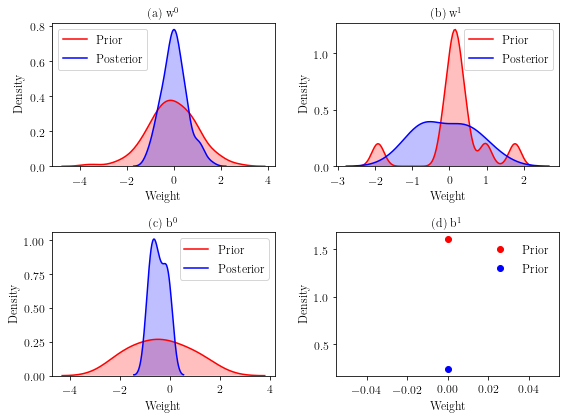

In [211]:
plot_weight_distribution()

### Statistics on prior and posterior weigth distribution

In [214]:
for i, wt in enumerate(wgt):
    print(wt)
    print(np.mean(prior_weights[i].reshape(-1)))
    print(np.mean(post_weights_mean[i].reshape(-1)))
    print(np.std(prior_weights[i].reshape(-1)))
    print(np.std(post_weights_mean[i].reshape(-1)))

w$^0$
-0.056490015
0.0336118
1.0278634
0.5250203
w$^1$
0.17717205
-0.09415656
0.80817145
0.7283847
b$^0$
-0.3824927
-0.43993047
1.1170884
0.29290244
b$^1$
1.6093408
0.23902255
0.0
0.0


### Model weights mean and standard deviation

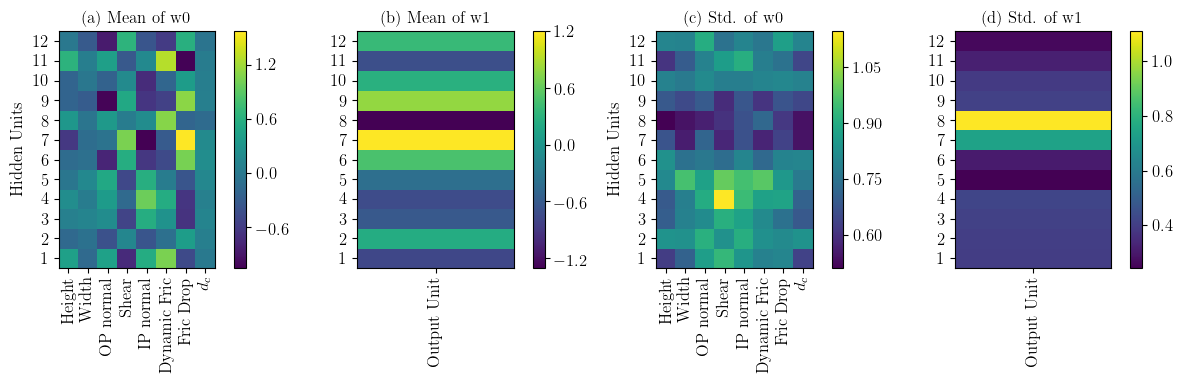

In [436]:
# %matplotlib notebook

plt.figure(figsize=(12, 4))

wgt = ['Mean of w0', 'Mean of w1', 'Std. of w0', 'Std. of w1']
lbl = ['a', 'b', 'c', 'd']

k = 0
for i in range(2):
    if i == 0:
        weights = post_weights_mean
    else:
        weights = post_weights_std
        
    plt.subplot(1,4, k + i + 1)
    aa = np.transpose(weights[0])
    plt.pcolormesh(aa, cmap = 'viridis', vmin = np.min(weights[0]), vmax = np.amax(weights[0]))
    labels = ['Height', 'Width', 'OP normal', 'Shear', 'IP normal', 'Dynamic Fric', 'Fric Drop', '$d_c$']

    plt.xticks([0.5+float(x) for x in range(0,8)], labels, rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
    plt.ylabel('Hidden Units')
    plt.title('('+ lbl[k + i] + ') ' + wgt[k + i])

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

    cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()

    # Layer two plot
    plt.subplot(1, 4, k+i+2)
    bb = np.reshape(weights[1], (12, 1))
    plt.pcolormesh(bb, cmap = 'viridis', vmin = np.min(weights[1]), vmax = np.amax(weights[1]))
    plt.xticks([0.5],['Output Unit'],rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
    plt.title('('+ lbl[k+i+1] + ') ' + wgt[k+i+1])

    cb = plt.colorbar(orientation="vertical",fraction=0.07, pad=0.1)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    k = 1

plt.tight_layout()
plt.savefig('../paper/figures/network_uncertainity.eps')
plt.show()

### Evaluation

In [221]:
###
results = pd.DataFrame()
results['target'] = list(ytest)
results.target = results.target.apply(lambda x: int(x[0]))

In [222]:
results['predictions'] = predictions_samp.mean(axis = 0)
results['predStd'] = predictions_samp.std(axis = 0)
results['predVar'] = predictions_samp.var(axis = 0)

In [223]:
zzz = stats.norm.interval(0.95, loc = results['predictions'], scale = results['predStd'])
results['confidenceLow'] = np.transpose(zzz)[:, 0]
results['confidenceHigh'] = np.transpose(zzz)[:, 1]
results['confidenceRange'] = np.absolute(results['confidenceHigh'] - results['confidenceLow'])

In [232]:
df_test.label.value_counts()

0.0    272
1.0    128
Name: label, dtype: int64

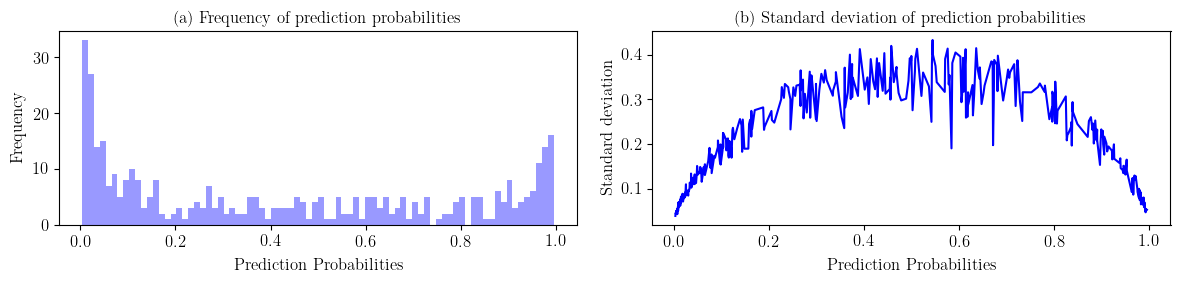

In [252]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
sns.distplot(results.predictions, kde = False, bins = 80, color = 'blue')
plt.xlabel('Prediction Probabilities')
plt.title('(a) Frequency of prediction probabilities')
plt.ylabel('Frequency')

plt.subplot(122)
sns.lineplot(x = "predictions", y = "predStd", data = results, color = 'blue')
plt.xlabel('Prediction Probabilities')
plt.title('(b) Standard deviation of prediction probabilities')
plt.ylabel('Standard deviation')
plt.tight_layout()
plt.savefig('../paper/figures/uncertainity_statistics.eps')
# plt.show()

In [46]:
fpr, tpr, thresholds = metrics.roc_curve(ytest, results.predictions, pos_label=1)
p = figure(plot_width=600, plot_height=400, tools = TOOLS, x_axis_label = 'False positive rate', y_axis_label = 'True positive rate', title = 'ROC-AUC score: {}'.format(roc_auc_score(ytest, results.predictions)))
p.line(x = fpr, y = tpr, line_width=2, color = 'blue')
p.line(x = tpr, y = thresholds, line_width = 2, color = 'red')
show(p)

In [133]:
def get_optimal_threshold():  
    thresholds = list(np.linspace(0, 1, 400))
    f1_scores = []
    for threshold in thresholds:
        ypred = results.predictions.apply(lambda x: 1 if x >= threshold else 0)
        f1_scores.append(f1_score(ytest, ypred, average = 'weighted'))
        
    return print('Threshold:{}, f1_score: {}'.format(th[np.argmax(f1_scores)]))

In [134]:
f1_scores, th = get_optimal_threshold()

/Users/sabber/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sabber/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sabber/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sabber/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


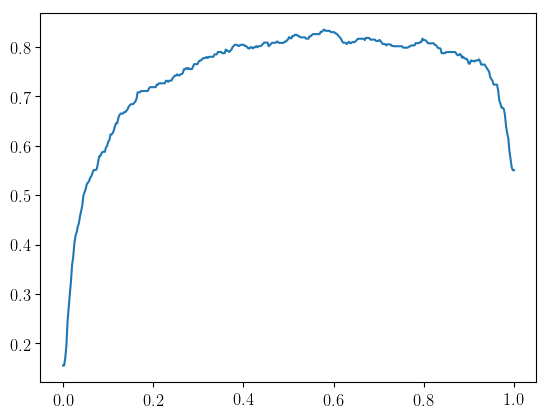

In [138]:
plt.plot(th, f1_scores)
plt.show()

In [406]:
th[np.argmax(f1_scores)]

0.5789473684210527

In [408]:
threshold = 0.50
results['binPred'] = results.predictions.apply(lambda x: 1 if x >= threshold else 0)

def prediction(ytest, ypred):
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('F1-score of the model: {}\n'.format(f1_score(ytest, ypred, average='weighted')))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

prediction(ytest, results['binPred'])

Accuracy of the model: 0.815

F1-score of the model: 0.819848991478805

Classification report: 
             precision    recall  f1-score   support

        0.0       0.92      0.80      0.85       272
        1.0       0.66      0.85      0.75       128

avg / total       0.84      0.81      0.82       400


Confusion matrix: 
[[217  55]
 [ 19 109]]



### Prediction on the 

In [140]:
all_samples = pd.DataFrame(predictions_samp).applymap(lambda x: 1 if x >= threshold else 0)

In [141]:
results.head()

,target,predictions,pred_std,pred_var,confidence_low,confidence_high,confidence_range,bin_pred,pca_x1,pca_x2
0,0,0.096194,0.171539,0.029426,-0.240016,0.432404,0.672420,0,0.557490,-1.138433
1,1,0.989023,0.058163,0.003383,0.875025,1.103020,0.227995,1,0.372588,2.210410
2,0,0.075511,0.191114,0.036524,-0.299065,0.450087,0.749151,0,-2.883425,-0.418066
3,0,0.123666,0.230987,0.053355,-0.329061,0.576393,0.905454,0,0.412756,-1.462043
4,1,0.705614,0.347966,0.121081,0.023612,1.387615,1.364004,1,2.860224,0.236508


In [142]:
accuracies = []
for i in range(n_samples):
    ypred = all_samples.iloc[i]
    accuracies.append(f1_score(ytest, ypred, average='weighted'))

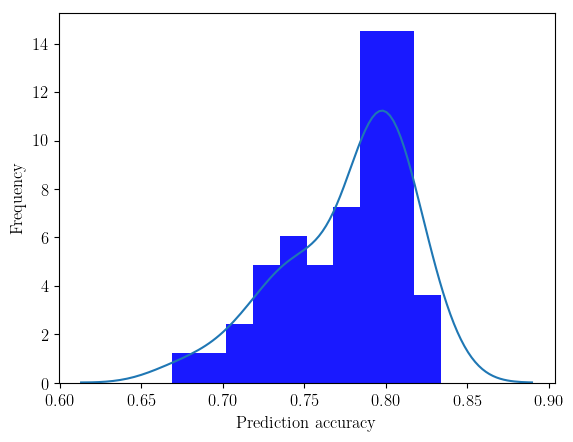

In [176]:
percent = [1]

for i in range(len(percent)):
    smapled_acc = np.random.choice(accuracies, size = int((percent[i]*n_samples)/100), replace = False)
    sns.distplot(smapled_acc, bins = 10, hist_kws={"linewidth":3, "alpha": 0.9, "color": "b"})
    plt.ylabel('Frequency')
    plt.xlabel('Prediction accuracy')
plt.show()

In [144]:
print(np.std(accuracies)*2, np.mean(accuracies), np.max(accuracies))

0.09186598014811123 0.7706648509487338 0.861076436001809


### Error analysis

In [413]:
correct = results[(results.target == results.binPred)]
incorrect = results[(results.target != results.binPred)]

In [415]:
incorrect.confidenceRange[(incorrect.binPred == 0)].mean(axis = 0)

1.2171376492543349

In [416]:
correct.confidenceRange[(correct.binPred == 0)].mean(axis = 0)

0.7350277600278647

In [417]:
def plot_distribution(i):
    xxx = samplepredictions[:, i, 0]
    ax = sns.distplot(xxx, kde = False, fit=stats.gamma)
    ax2 = ax.twinx()
    sns.boxplot(x=xxx, ax=ax2)
    ax2.set(ylim=(-.5, 10))
    plt.show()

Actual: 0.0, Prediction: 0.0, pred_proba: 0.16277918219566345, std: 0.25408199429512024


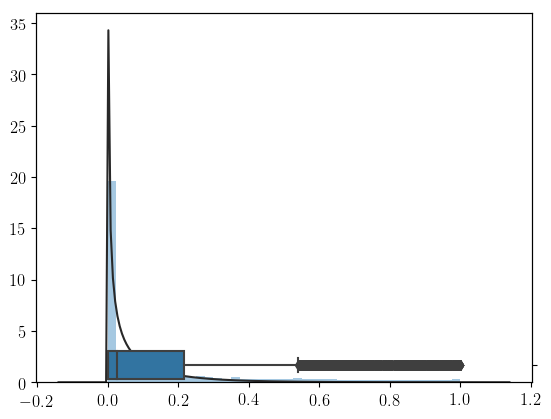

In [418]:
example = 200
print('Actual: {}, Prediction: {}, pred_proba: {}, std: {}'.format(results.iloc[example].target, 
                                                                   results.iloc[example].binPred,
                                                                   results.iloc[example].predictions,
                                                                   results.iloc[example].predStd))
plot_distribution(example)

### Result vizualisation

In [254]:
pca = PCA(n_components = 2, random_state = 2018).fit_transform(xtest)

results['pca_x1'] = pca[:, 0]
results['pca_x2'] = pca[:, 1]

In [255]:
results.head()

,target,predictions,predStd,predVar,confidenceLow,confidenceHigh,confidenceRange,pca_x1,pca_x2
0,0,0.096194,0.171539,0.029426,-0.240016,0.432404,0.672420,0.557490,-1.138433
1,1,0.989023,0.058163,0.003383,0.875025,1.103020,0.227995,0.372588,2.210410
2,0,0.075511,0.191114,0.036524,-0.299065,0.450087,0.749151,-2.883425,-0.418066
3,0,0.123666,0.230987,0.053355,-0.329061,0.576393,0.905454,0.412756,-1.462043
4,1,0.705614,0.347966,0.121081,0.023612,1.387615,1.364004,2.860224,0.236508


In [405]:
results.shape

(400, 9)

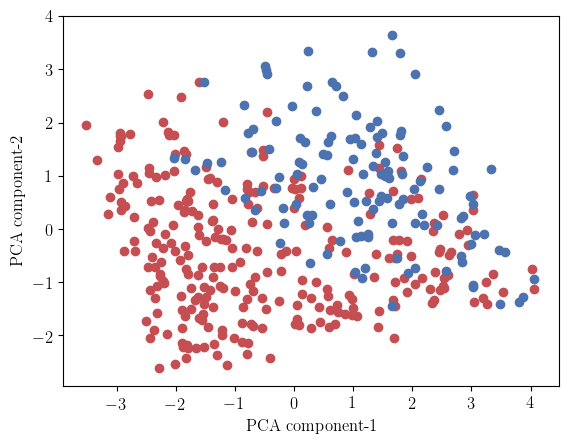

In [256]:
plt.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r')
plt.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b')

plt.xlabel('PCA component-1')
plt.ylabel('PCA component-2')
plt.show()

In [375]:
xi = np.linspace(-4, 4, 1000)
yi = np.linspace(-3, 4, 1000)
x, y = results.pca_x1, results.pca_x2

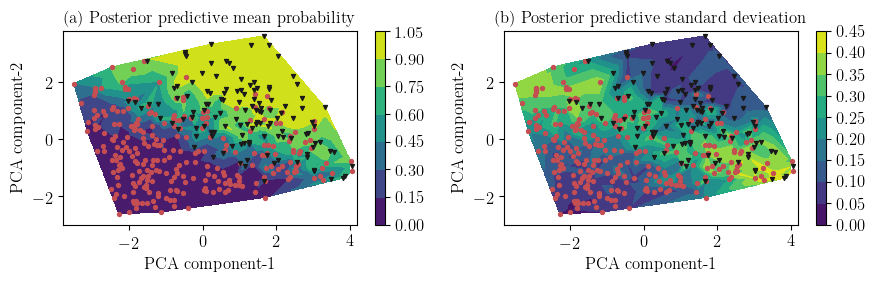

In [404]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(9, 3))
cmap = 'viridis'
axes = [ax1, ax2]
titles = ['(a) Posterior predictive mean probability', '(b) Posterior predictive standard devieation']
datas = [results.predictions, results.predStd]

for ax, data, title in zip(axes, datas, titles):
    zi = griddata(x, y, data, xi, yi, interp = 'linear')
#     ax.contour(xi, yi, zi, levels = 14, linewidths = 0.5, colors = 'k')
    contour = ax.contourf(xi, yi, zi, cmap = cmap)
    ax.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r', s = 8, marker = 'o')
    ax.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'k', s = 8, marker = 'v')
    ax.set_title(title)
    cbar = plt.colorbar(contour, ax = ax)
    _ = ax.set(xlim = (-3.8, 4.2), ylim = (-3, 3.8), xlabel = 'PCA component-1', ylabel = 'PCA component-2')
fig.tight_layout()
fig.savefig('../paper/figures/posterior_proba_uncertainity.eps')

In [409]:
err = results[results.target != results.binPred]

In [428]:
corr = results[results.target == results.binPred]

In [411]:
err.describe()

,target,predictions,predStd,predVar,confidenceLow,confidenceHigh,confidenceRange,pca_x1,pca_x2,binPred
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,0.256757,0.640993,0.298380,0.094139,0.056179,1.225806,1.169627,0.705847,0.477495,0.743243
std,0.439826,0.200364,0.071961,0.040062,0.302540,0.168956,0.282082,1.750176,1.006893,0.439826
min,0.000000,0.231905,0.083762,0.007016,-0.397335,0.777348,0.328339,-2.784677,-1.448623,0.000000
25%,0.000000,0.485653,0.253210,0.064117,-0.199816,1.139595,0.992565,-0.662105,-0.289266,0.250000
50%,0.000000,0.645686,0.307637,0.094640,-0.004588,1.282790,1.205914,1.083773,0.565935,1.000000
75%,0.750000,0.796157,0.347147,0.120517,0.288460,1.342967,1.360791,2.027685,1.164689,1.000000
max,1.000000,0.979348,0.432855,0.187363,0.815178,1.467741,1.696760,4.062086,2.756970,1.000000


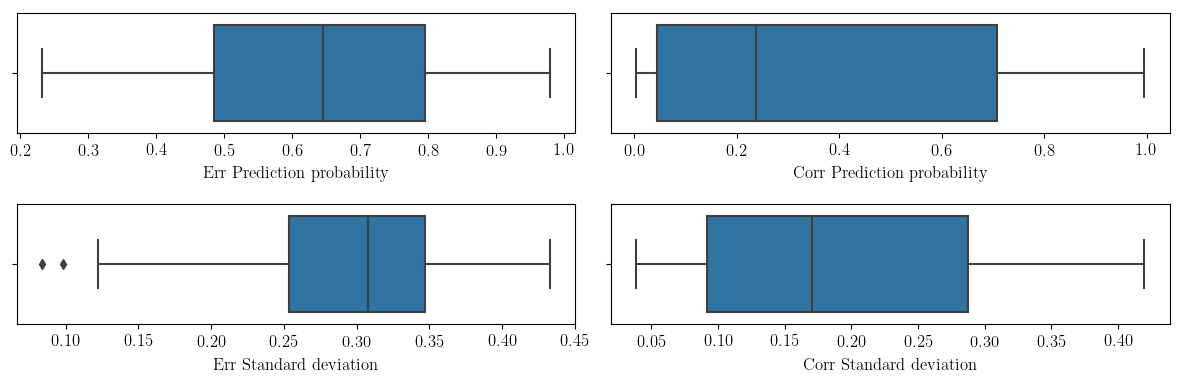

In [432]:
plt.figure(figsize=(12,4))
plt.subplot(221)
sns.boxplot(x = err.predictions, y = None)
plt.xlabel('Err Prediction probability')

plt.subplot(222)
sns.boxplot(x = corr.predictions, y = None)
plt.xlabel('Corr Prediction probability')

plt.subplot(223)
sns.boxplot(x = err.predStd, y = None)
plt.xlabel('Err Standard deviation')

plt.subplot(224)
sns.boxplot(x = corr.predStd, y = None)
plt.xlabel('Corr Standard deviation')
plt.tight_layout()

In [427]:
err.head(80)

,target,predictions,predStd,predVar,confidenceLow,confidenceHigh,confidenceRange,pca_x1,pca_x2,binPred
11,0,0.653737,0.330573,0.109279,0.005825,1.301650,1.295824,1.903802,-0.219167,1
23,0,0.680182,0.376888,0.142045,-0.058505,1.418869,1.477374,2.447646,-0.432597,1
36,1,0.455151,0.348545,0.121484,-0.227985,1.138287,1.366272,-1.853602,1.314722,0
38,0,0.699975,0.342952,0.117616,0.027801,1.372148,1.344347,-2.125762,1.826622,1
42,0,0.576175,0.413505,0.170987,-0.234280,1.386630,1.620911,3.241921,-0.990133,1
49,1,0.401850,0.321644,0.103455,-0.228560,1.032260,1.260821,0.553478,-0.473397,0
66,1,0.255578,0.307534,0.094577,-0.347177,0.858334,1.205511,-0.552027,0.717440,0
67,1,0.273208,0.257219,0.066162,-0.230932,0.777348,1.008280,0.275000,-0.637059,0
68,1,0.231905,0.303235,0.091951,-0.362424,0.826235,1.188659,1.934951,-0.834562,0
74,0,0.890444,0.232057,0.053851,0.435620,1.345269,0.909648,-1.611167,2.756970,1


In [519]:
aa = np.reshape(xtest[3], (8,1)) * post_weights_mean[0]
bb = aa.sum(axis = 0)
z1 = np.reshape(bb * (bb > 0), (12, 1))
out = np.sum(z1 * np.reshape(post_weights_mean[2], (12, 1)), axis = 0)
prob = 1 / (1 + math.exp(-out))
print(prob)

0.021367417953553545


In [515]:
results.head()

,target,predictions,predStd,predVar,confidenceLow,confidenceHigh,confidenceRange,pca_x1,pca_x2,binPred
0,0,0.096194,0.171539,0.029426,-0.240016,0.432404,0.672420,0.557490,-1.138433,0
1,1,0.989023,0.058163,0.003383,0.875025,1.103020,0.227995,0.372588,2.210410,1
2,0,0.075511,0.191114,0.036524,-0.299065,0.450087,0.749151,-2.883425,-0.418066,0
3,0,0.123666,0.230987,0.053355,-0.329061,0.576393,0.905454,0.412756,-1.462043,0
4,1,0.705614,0.347966,0.121081,0.023612,1.387615,1.364004,2.860224,0.236508,1


### Network Uncertainity

In [550]:
# plt.figure(figsize= (12, 3))
# plt.subplot(151)
# plt.pcolormesh(post_weights_mean[0])

# plt.subplot(152)
# plt.pcolormesh(post_weights_mean[1])

# plt.subplot(143)
# plt.pcolormesh(post_weights_mean[1])

# plt.subplot(144)
# plt.pcolormesh(post_weights_mean[3])

In [551]:
# np.multiply(post_weights_mean[0], (xtest[0]))

### CRITICISM

In [530]:
results.head()

,target,predictions,predStd,predVar,confidenceLow,confidenceHigh,confidenceRange,pca_x1,pca_x2,binPred
0,0,0.096194,0.171539,0.029426,-0.240016,0.432404,0.672420,0.557490,-1.138433,0
1,1,0.989023,0.058163,0.003383,0.875025,1.103020,0.227995,0.372588,2.210410,1
2,0,0.075511,0.191114,0.036524,-0.299065,0.450087,0.749151,-2.883425,-0.418066,0
3,0,0.123666,0.230987,0.053355,-0.329061,0.576393,0.905454,0.412756,-1.462043,0
4,1,0.705614,0.347966,0.121081,0.023612,1.387615,1.364004,2.860224,0.236508,1


In [564]:
# threshold = 0.50
# import sys

def considerUncertainity(threshold, std):
    
    if threshold > 0.5 and std > 0.30:
        return 0
#     if threshold < 0.5 and std > 0.20:
#         return 1
#     elif threshold > 0.5 and std < 0.20:
#         return 1
    elif threshold < 0.5:
        return 0
    
    elif threshold > 0.5:
        return 1

uncertainityBinPred = []

for i in range(400):
    (th, std) = results.iloc[i]['predictions'], results.iloc[i]['predStd']
    uncertainityBinPred.append(considerUncertainity(th.astype('float'), std.astype('float')))

In [565]:
prediction(ytest, uncertainityBinPred)

Accuracy of the model: 0.8225

F1-score of the model: 0.8183801365499771

Classification report: 
             precision    recall  f1-score   support

        0.0       0.85      0.90      0.87       272
        1.0       0.76      0.65      0.70       128

avg / total       0.82      0.82      0.82       400


Confusion matrix: 
[[246  26]
 [ 45  83]]



In [ ]:
import matplotlib.pyplot as plt

y = np.random.randn(20)
y_rep = np.random.randn(20, 20)

ed.ppc_density_plot(y, y_rep)
plt.show()

In [ ]:
def define_network(images, num_classes=10):
    
     mean = tf.get_variable('mean', [28 * 28, num_classes])
     stddev = tf.get_variable('stddev', [28 * 28, num_classes])
     prior = tfd.MultivariateNormalDiag(
     tf.zeros_like(mean), tf.ones_like(stddev))
     posterior = tfd.MultivariateNormalDiag(mean, tf.nn.softplus(stddev))
     bias = tf.get_variable('bias', [num_classes]) # Or Bayesian, too
     logit = tf.nn.relu(tf.matmul(posterior.sample(), images) + bias)
     return tfd.Categorical(logit), posterior, prior

In [ ]:
dist, posterior, prior = define_network(images)
elbo = (tf.reduce_mean(dist.log_prob(label)) -
 tf.reduce_mean(tfd.kl_divergence(posterior, prior))